- Ссылка на github  https://github.com/peter9405/masterskay 
- Дополнительные датасеты которые пришлось загрузить там же, train и test не выкладываю по указанию учителя.

## Введение

- Цель проекта разработать модель для предсказания успешности стартапа (закроется или нет)
- Данные состоят из 2х файлов, тренировочный набор (около 53к записей) и тестовый набор (около 13к записей)
- Проект состоит из нескольких частей:
  - предобработка данных
  - исследовательский анализ данных
  - создание синтетических входных признаков
  - корреляционный анализ Фик и отбор признкаков
  - подбор модели МО на тренировочном наборе с перебором параметров и моделей в пайплайне. Метрика качества F1
  - формирование прогноза для тестовой выборки лучшей моделью

In [1]:
!pip install requests
!pip install fuzzywuzzy[speedup]
!pip install pycountry
##!pip install --upgrade certifi
!pip install kaggle
!pip install catboost


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from collections import Counter
import pycountry
import numpy as np
import phik

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

## Загрузка данных

In [3]:
train = pd.read_csv('./kaggle_startups_train_28062024.csv')
test = pd.read_csv('./kaggle_startups_test_28062024.csv')

In [4]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [5]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


## Предобработка данных

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


__Приведем поля с датами к корректоному формату__

In [8]:
for i in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']:
    train[i] = pd.to_datetime(train[i], errors='coerce')

In [9]:
for i in ['first_funding_at', 'last_funding_at']:
    test[i] = pd.to_datetime(test[i], errors='coerce')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


__Проверим датасеты на явные дубли__

In [12]:
train.duplicated().sum()

0

In [13]:
test.duplicated().sum()

0

__Явные дубли отсутствуют__

In [14]:
train[train['name'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [15]:
train['name'].nunique()

52515

In [16]:
test['name'].nunique()

13125

__У одного стартапа в трейн не указано имя. В остальном имена уникальные__

In [17]:
train.category_list.isna().sum()

2465

In [18]:
train[train['category_list'].isna()].head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-08-11
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-11-03
26,The Center from Health Promotion,NaN,10000000.0,operating,NaN,NaN,NaN,NaN,1,2002-04-21,2003-11-12,2003-11-12,NaT
64,Seamless Logistics,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2009-02-22,2011-02-01,2011-02-01,NaT


__В трейн и в тест есть ряд компаний без указанных категорий.__
- Проверил базу данных с стартапами CrunchBase, к сожалению, на примере Seamless Logistics, The Center from Health Promotion founded_at из датасетов не совпадает с указанным на сайте, а Savasti совпадает.
- API подключить не удалось, ошибка корректности ключа user. Ниже представлен код попытки
- Заполнить пропуски в категориях не представляется возможным

In [19]:
#api_key = '46fd3d384bda4c87a1da5fa7f326f16d'
#organization_name = 'savasti'
#url = f"https://api.crunchbase.com/v3.1/organizations/{organization_name}?user_key={api_key}"

# Make the API request
#response = requests.get(url)

# Handle the response
#if response.status_code == 200:
#    data = response.json()  # Parse JSON data from the response
#    print(data)             # Print or process the retrieved data
#elif response.status_code == 401:
#    print("Error 401: Unauthorized. Check if your API key is correct.")
#else:
#    print(f"Error: {response.status_code}")

In [20]:
train.category_list.nunique()

22105

In [21]:
test.category_list.nunique()

6206

In [22]:
category_list = sorted(train['category_list'].dropna().unique().tolist())
category_list

['3D',
 '3D Printing',
 '3D Printing|3D Technology',
 '3D Printing|3D Technology|Android|Artificial Intelligence|Drones|Enterprise Application|Entertainment|Entrepreneur|Games|Lasers|Mobile|Open Source|Robotics|Telecommunications',
 '3D Printing|3D Technology|Android|Games|iOS|Mobile|Mobile Games|Mobile Software Tools|Serious Games|Tablets|Video Games',
 '3D Printing|3D Technology|Audio|Mass Customization',
 '3D Printing|3D Technology|CAD|Cloud Gaming|Printing',
 '3D Printing|3D Technology|Consumer Electronics',
 '3D Printing|3D Technology|Creative Industries',
 '3D Printing|3D Technology|DIY|Printing|Software',
 '3D Printing|3D Technology|Education',
 '3D Printing|3D Technology|Graphics',
 '3D Printing|3D Technology|Manufacturing|Photography',
 '3D Printing|3D Technology|Mobile Games',
 '3D Printing|3D Technology|Startups',
 '3D Printing|Advanced Materials|Electric Vehicles|Energy|Hardware|Health Care|High Tech|Incubators|Internet of Things|Medical Devices|Robotics|Startups',
 '3D Pri

__Имеем 22 105 уникальных категорий в трейн и 6 206 в тест__

__Приведем поле category_list к списку__

In [23]:
train['category_list'] = train['category_list'].str.split('|')

In [24]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,"[Online Reservations, Restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,"[Manufacturing, Medical, Medical Devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,[Biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,[Health Care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,[Manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


__Приведем элементы списка категорий к нижнему регистру и избавимся от возможных пробелов__

In [25]:
train['category_list'] = train['category_list'].apply(lambda x: [category.strip().lower() for category in x] if isinstance(x, list) else x)

In [26]:
train['category_list'] = train['category_list'].apply(lambda x: x if isinstance(x, list) else [])

In [27]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [28]:
flattened_categories = [category for sublist in train['category_list'] for category in sublist]
unique_categories = list(set(flattened_categories))

In [29]:
len(unique_categories)

854

- __Имеем 854 уникальных названий категорий__
- __Попробуем использовать библиотеку fuzzy для объеденения категорий по схожести текста__

In [30]:
def find_similar_categories(category, all_categories, threshold=85):
    matches = process.extract(category, all_categories, limit=5)  
    return [match for match, score in matches if score >= threshold]  

similar_categories = {category: find_similar_categories(category, unique_categories) for category in unique_categories}

for category, matches in similar_categories.items():
    print(f"{category}: {matches}")


social + mobile + local: ['social + mobile + local', 'local', 'mobile', 'mobile devices', 'social commerce']
digital rights management: ['digital rights management', 'event management', 'it management', 'waste management', 'digital signage']
event management: ['event management', 'fleet management', 'digital rights management', 'intellectual asset management', 'vulnerability management']
visual search: ['visual search', 'search']
internet of things: ['internet of things', 'internet', 'internet tv']
mmo games: ['mmo games', 'games', 'game', 'educational games']
public safety: ['public safety', 'public transportation', 'general public worldwide']
angels: ['angels']
internet radio market: ['internet radio market', 'internet', 'china internet', 'farmers market', 'internet tv']
user testing: ['user testing', 'testing', 'user experience design']
bpo services: ['bpo services', 'services', 'local based services', 'postal and courier services', 'product development services']
new technologies: 

__Не очень хороший результат. Например task management: ['task management', 'risk management', 'web presence management', 'social media management', 'vulnerability management'], eda tools: ['eda tools', 'developer tools', 'mobile software tools', 'customer support tools']__

__Попробуем векторизацию с помощью TF-IDF (Term Frequency-Inverse Document Frequency) и KMEANS__

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(unique_categories)

num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

cluster_labels = kmeans.labels_
clustered_categories = pd.DataFrame({'category': unique_categories, 'cluster': cluster_labels})

print(clustered_categories.sort_values(by='cluster').head(60))


                          category  cluster
280               social investing        0
319               impact investing        0
188            creative industries        1
133                       creative        1
740                          cyber        2
734                 cyber security        2
559     internet service providers        3
542                 infrastructure        3
523           cloud infrastructure        3
649          mobile infrastructure        3
599                    internet tv        3
158             internet marketing        3
480              consumer internet        3
472             proximity internet        3
256                 china internet        3
710        internet infrastructure        3
757        infrastructure builders        3
746            internet technology        3
137                       internet        3
8            internet radio market        3
4               internet of things        3
619                 product sear

__Получше, но судя по первому кластеру, тоже не очень, biotechnology and semiconductor, it and cybersecurity, oil and gas, wine and spirits в одном кластере__

__Попробуем openai чтобы создать словарь с категориями и создадим новую колонку в train__

In [32]:
category_mapping_full = {
    # Technology
    'software': 'technology',
    'mobile': 'technology',
    'biotechnology': 'technology',
    'enterprise software': 'technology',
    'saas': 'technology',
    'analytics': 'technology',
    'apps': 'technology',
    'clean technology': 'technology',
    'hardware + software': 'technology',
    'cloud computing': 'technology',
    'big data': 'technology',
    'internet': 'technology',
    'technology': 'technology',

    # Social Media & Marketing
    'social media': 'marketing',
    'advertising': 'marketing',
    'curated web': 'marketing',
    'video': 'marketing',
    'social media marketing': 'marketing',
    'facebook applications': 'marketing',
    'social crm': 'marketing',
    'ad targeting': 'marketing',
    
    # Healthcare
    'health care': 'healthcare',
    'health and wellness': 'healthcare',
    'medical': 'healthcare',
    'medication adherence': 'healthcare',
    'mhealth': 'healthcare',
    'nutrition': 'healthcare',
    'elder care': 'healthcare',
    'electronic health records': 'healthcare',
    'healthcare services': 'healthcare',
    'health services industry': 'healthcare',
    'physicians': 'healthcare',
    'doctors': 'healthcare',
    
    # Finance & Investment
    'finance': 'finance',
    'trading': 'finance',
    'risk management': 'finance',
    'billing': 'finance',
    'transaction processing': 'finance',
    'moneymaking': 'finance',
    'pre seed': 'finance',
    'hedge funds': 'finance',
    'venture capital': 'finance',
    
    # E-commerce & Retail
    'e-commerce': 'retail',
    'marketplaces': 'retail',
    'custom retail': 'retail',
    'gift registries': 'retail',
    'ticketing': 'retail',
    'wholesale': 'retail',
    'vending and concessions': 'retail',
    'auctions': 'retail',
    'groceries': 'retail',

    # Media & Broadcasting
    'broadcasting': 'media',
    'video streaming': 'media',
    'concerts': 'media',
    'tv station': 'media',
    
    # Gaming
    'games': 'gaming',
    'video games': 'gaming',
    'cloud gaming': 'gaming',
    'video game tournaments': 'gaming',
    'serious games': 'gaming',
    
    # Environment & Energy
    'energy': 'energy',
    'renewable tech': 'energy',
    'biomass power generation': 'energy',
    'oil & gas': 'energy',
    'natural resources': 'energy',
    
    # Education
    'education': 'education',
    'training': 'education',
    'language learning': 'education',
    'teaching stem concepts': 'education',
    'university students': 'education',
    
    # Business Services
    'services': 'business services',
    'public relations': 'business services',
    'field support services': 'business services',
    'direct sales': 'business services',
    'enterprise security': 'business services',
    
    # Mobility & Transport
    'mobility': 'mobility',
    'gps': 'mobility',
    'bicycles': 'mobility',

    # Fashion & Entertainment
    'fashion': 'fashion',
    'entertainment': 'arts and entertainment',
    'music venues': 'arts and entertainment',
    'film distribution': 'arts and entertainment',
    'art': 'arts and entertainment',

    # Security
    'security': 'security',
    'network security': 'security',
    'law enforcement': 'security',

    # Miscellaneous
    'technology': 'technology',
    'social investing': 'social networking',
    'collaborative consumption': 'social networking',
    'private social networking': 'social networking',
}

In [33]:
train['standardized_category'] = train['category_list'].apply(
    lambda categories: [category_mapping_full.get(category, category) for category in categories]
)

In [34]:
flattened_standardized_categories = [category for sublist in train['standardized_category'] for category in sublist]

In [35]:
standardized_category_counts = Counter(flattened_standardized_categories)

In [36]:
standardized_category_counts

Counter({'technology': 28809,
         'marketing': 8185,
         'retail': 5154,
         'healthcare': 4790,
         'finance': 2021,
         'gaming': 1917,
         'business services': 1866,
         'education': 1794,
         'media': 1095,
         'manufacturing': 1080,
         'security': 1051,
         'arts and entertainment': 923,
         'fashion': 832,
         'real estate': 734,
         'consulting': 729,
         'travel': 724,
         'information technology': 719,
         'music': 676,
         'networking': 670,
         'search': 670,
         'social network media': 663,
         'news': 649,
         'sales and marketing': 633,
         'hospitality': 633,
         'startups': 631,
         'sports': 628,
         'financial services': 611,
         'design': 588,
         'fintech': 588,
         'web hosting': 576,
         'semiconductors': 565,
         'messaging': 540,
         'digital media': 487,
         'photography': 465,
         'web develo

__К сожалению словарь далеко не полон и у нас все также уйма категорий. Пожалуй, не будем использовать категории как входной признак для нашей модели так как с оптимизацией и аггрегацией категорий справиться не удалось__

__Пропуски в данных мы заполним в пайплайне обработки данных__

## Исследовательский анализ данных

In [37]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [38]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,standardized_category
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,"[online reservations, restaurants]"
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,"[manufacturing, healthcare, medical devices]"
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,[technology]
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,[healthcare]
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,[manufacturing]


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      42447 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              4917 non-null   datetime64[ns]
 13  s

In [40]:
train.describe()

,funding_total_usd,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,4.244700e+04,52516.000000,52516,52516,52516,4917
mean,1.824748e+07,1.740670,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812544
min,1.000000e+00,1.000000,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,3.360275e+05,1.000000,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,2.000000e+06,1.000000,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,1.000000e+07,2.000000,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,3.007950e+10,19.000000,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00
std,1.871173e+08,1.374522,NaN,NaN,NaN,NaN


In [41]:
def exploratory_analysis(df):
    num_discrete_cols = df.select_dtypes(include=[int]).columns
    num_cont_cols = df.select_dtypes(include=['float64']).columns
    
    for i in num_cont_cols:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        bins= ax1.hist(x=df[i])
        ax1.vlines(x=df[i].mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
        ax1.vlines(x=df[i].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
        ax1.set_title(f'Гистограмма распределения: {i}')
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax1.legend(loc='upper right', framealpha=0.3)
        
        ax2.boxplot(df[i], vert=False)
        ax2.set_title(f'Boxplot: {i}')
        ax2.set_xlabel('Значения')
        ax2.set_yticks([])
        y = np.ones_like(df[i])  
        ax2.scatter(df[i], y, color='blue', alpha=0.5, label='Значения')
        ax2.legend(loc='upper right')
        
        
        plt.show()
        
    for i in num_discrete_cols:
        sns.set(style="whitegrid")
        plt.figure(figsize=(8, 4))
        ax = sns.countplot(x=i, data=df, edgecolor="black", linewidth=1.5)
        plt.title(f'Распределение {i}')
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')
        plt.show()

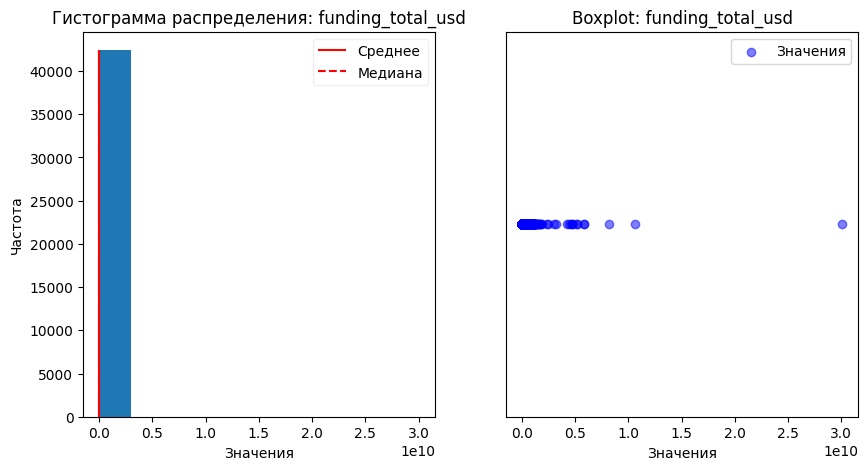

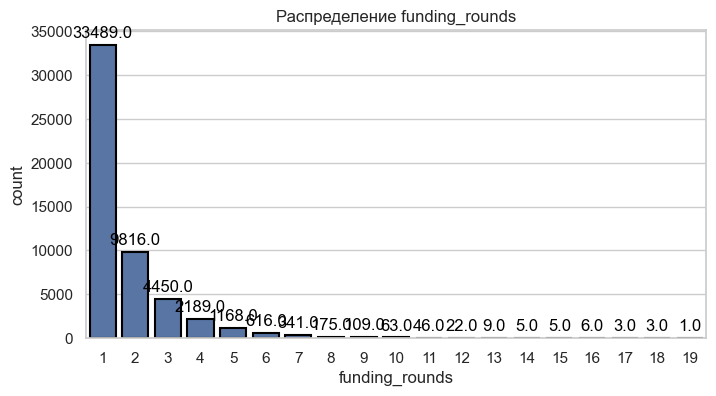

In [42]:
exploratory_analysis(train)

__Итак__:
- Имеем всего 2 количественных признака, дискретный кол во funding_rounds и continuous funding_total_usd
- funding_rounds подавляющее большиство 33 489 стартапов имело 1 круг финансирования
- funding_total_usd среднее немного меньше медианны, 1.824748e+07 против 2.000000e+06. Соответственно распределение смещено влево


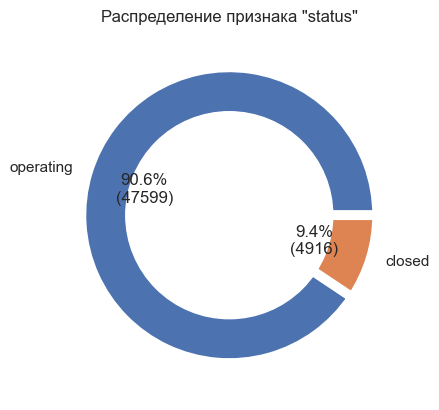

In [43]:

my_circle = plt.Circle( (0,0), 0.7, color='white')
y = train['status'].value_counts()
x = train['status'].unique()
plt.pie(y, labels=x,autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(y))})',wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title(f'Распределение признака "{'status'}"')
plt.show()

__Категориальные признаки__:
- Целевой признак статус отображен на пайчарте. 90,6 % стартапов остались в рабочем статусе, и только 4 916 закрылись на начало 2018г.
- Остальные категориальные признаки имеют много уникальных значений и я предлагаю создать новые синтетические признаки на их основе

In [44]:
train['country_code'].value_counts()

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: count, Length: 134, dtype: int64

In [45]:
train['state_code'].value_counts()

state_code
CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
      ...  
PE        1
Y1        1
O2        1
V3        1
U6        1
Name: count, Length: 300, dtype: int64

In [46]:
train['region'].value_counts()

region
SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
Los Angeles            1513
                       ... 
Helena                    1
Castelfranco Veneto       1
Taunton                   1
Vevey                     1
Doncaster                 1
Name: count, Length: 1036, dtype: int64

In [47]:
train['city'].value_counts()

city
San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         607
                 ... 
Beppu               1
Idukki              1
Reutlingen          1
Sulphur             1
Centreville         1
Name: count, Length: 4477, dtype: int64

### Добавление признаков

In [48]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [49]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,standardized_category
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,"[online reservations, restaurants]"
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,"[manufacturing, healthcare, medical devices]"
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,[technology]
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,[healthcare]
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,[manufacturing]


__Проверим что у закрытых стартапов у всех есть дата закрытия__

In [50]:
train[train['status'] == 'closed']['closed_at'].isna().sum()

0

__Так как у test предоставлен только lifetime, получим аналогичную величину в train, учитывая, что отчет мы делаем на дату 2018-01-01__

In [51]:
train['closed_at'].fillna(pd.Timestamp('2018-01-01'), inplace=True)
train['lifetime'] = train['closed_at'] - train['founded_at']
train['lifetime'] = train['lifetime'].dt.days.astype('int64')

C:\Users\Admin\AppData\Local\Temp\ipykernel_4232\845358447.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['closed_at'].fillna(pd.Timestamp('2018-01-01'), inplace=True)


__Также создадим входной признак кол-во дней между первым и последним раундом финансирования, а еще лучше сразу добавим этот шаг в пайплайн чтобы применить на тесте__

In [52]:
class DateDifferenceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, start_date_col, end_date_col, output_col, output_unit='days'):
        self.start_date_col = start_date_col
        self.end_date_col = end_date_col
        self.output_col = output_col
        self.output_unit = output_unit

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.output_col] = X[self.end_date_col] - X[self.start_date_col]
        
        if self.output_unit == 'days':
            X[self.output_col] = X[self.output_col].dt.days
        elif self.output_unit == 'seconds':
            X[self.output_col] = X[self.output_col].dt.total_seconds()
        elif self.output_unit == 'nanoseconds':
            X[self.output_col] = X[self.output_col].astype('int64')
        else:
            raise ValueError("output_unit must be 'days', 'seconds', or 'nanoseconds'")
        
        X[self.output_col] = X[self.output_col].astype('int64')
        return X

In [53]:
first_last_funding_pipe = Pipeline([
    ('date_diff', DateDifferenceTransformer(start_date_col='first_funding_at', end_date_col='last_funding_at', output_col='first_last_funding', output_unit='days')),
    
])


In [54]:
train = first_last_funding_pipe.fit_transform(train)

train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,standardized_category,lifetime,first_last_funding
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,"[online reservations, restaurants]",2998,1310
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,"[manufacturing, healthcare, medical devices]",4748,1393
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,[technology],4383,681
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,[healthcare],5114,1051
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,[manufacturing],2791,0


__Добавим метрику GDP per Capita и Gross GDP на 2018год для стран в которых находятся стартапы__

In [55]:
train['country_code'].nunique()

134

In [56]:
url_per_capita = "http://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD?date=2018&format=json&per_page=300"
response_per_capita = requests.get(url_per_capita)
data_per_capita = response_per_capita.json()

gdp_per_capita_data = []
for entry in data_per_capita[1]:
    country_code_2 = entry['country']['id']
    gdp_per_capita = entry['value']
    
    # Convert 2-letter code to 3-letter code using pycountry
    try:
        country_code_3 = pycountry.countries.get(alpha_2=country_code_2).alpha_3
        gdp_per_capita_data.append({'country_code': country_code_3, 'gdp_per_capita': gdp_per_capita})
    except AttributeError:
        # Skip countries that don't have a 3-letter code mapping
        continue

# Convert GDP per capita data to DataFrame
gdp_per_capita_df = pd.DataFrame(gdp_per_capita_data)

# Fetch gross GDP data for 2018 from the World Bank API
url_gross_gdp = "http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?date=2018&format=json&per_page=300"
response_gross_gdp = requests.get(url_gross_gdp)
data_gross_gdp = response_gross_gdp.json()

# Process gross GDP data
gross_gdp_data = []
for entry in data_gross_gdp[1]:
    country_code_2 = entry['country']['id']
    gross_gdp = entry['value']
    
    # Convert 2-letter code to 3-letter code using pycountry
    try:
        country_code_3 = pycountry.countries.get(alpha_2=country_code_2).alpha_3
        gross_gdp_data.append({'country_code': country_code_3, 'gross_gdp': gross_gdp})
    except AttributeError:
        # Skip countries that don't have a 3-letter code mapping
        continue

# Convert gross GDP data to DataFrame
gross_gdp_df = pd.DataFrame(gross_gdp_data)

# Merge GDP per capita and gross GDP data into a single DataFrame
gdp_df = pd.merge(gdp_per_capita_df, gross_gdp_df, on='country_code', how='outer')

# Merge with your train DataFrame on country_code
train = train.merge(gdp_df, on='country_code', how='left')

In [57]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,standardized_category,lifetime,first_last_funding,gdp_per_capita,gross_gdp
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,"[online reservations, restaurants]",2998,1310,85217.369151,7.255687e+11
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,"[manufacturing, healthcare, medical devices]",4748,1393,63201.045848,2.065652e+13
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,[technology],4383,681,63201.045848,2.065652e+13
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,[healthcare],5114,1051,NaN,NaN
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,[manufacturing],2791,0,63201.045848,2.065652e+13


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      42447 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              52516 non-null  datetime64[ns]
 13  s

__Попробуем создать метрику, является ли город стартапа столицей страны__

In [59]:
url = "https://restcountries.com/v3.1/all"
response = requests.get(url)
country_data = response.json()

# Create a dictionary to store country_code and capital city
country_capitals = {}

# Populate the dictionary with country codes and their capitals
for country in country_data:
    try:
        # Get 3-letter country code using pycountry for consistency
        country_code = pycountry.countries.get(alpha_2=country['cca2']).alpha_3
        capital = country['capital'][0] if 'capital' in country and country['capital'] else None
        if capital:
            country_capitals[country_code] = capital
    except AttributeError:
        # Skip entries without proper country code mappings
        continue

# Display a few entries from the dictionary to verify
print({k: country_capitals[k] for k in list(country_capitals)[:5]})

{'SGS': 'King Edward Point', 'GRD': "St. George's", 'CHE': 'Bern', 'SLE': 'Freetown', 'HUN': 'Budapest'}


In [60]:
def is_capital(row):
    country_code = row['country_code']
    city = row['city']
    
    # Check if the country code exists in the dictionary
    if country_code in country_capitals:
        # If city is missing, return 'no'
        if pd.isna(city):
            return 'no'
        # Check if the city matches the capital (case-insensitive comparison)
        return 'yes' if country_capitals[country_code].lower() == city.lower() else 'no'
    return np.nan  # Default to 'no' if country code or city is not in the dictionary

# Apply the function to create the 'capital' column
train['capital'] = train.apply(is_capital, axis=1)

In [61]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,standardized_category,lifetime,first_last_funding,gdp_per_capita,gross_gdp,capital
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,"[online reservations, restaurants]",2998,1310,85217.369151,7.255687e+11,no
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,"[manufacturing, healthcare, medical devices]",4748,1393,63201.045848,2.065652e+13,no
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,[technology],4383,681,63201.045848,2.065652e+13,no
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,[healthcare],5114,1051,NaN,NaN,NaN
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,[manufacturing],2791,0,63201.045848,2.065652e+13,no


In [62]:
train.capital.value_counts()

capital
no     40458
yes     6516
Name: count, dtype: int64

__Попробуем также добавить информацию о городах, как доля GDP города от страны и Employment at place of work из отчета OECD, который нам нужно будет загрузить__

In [63]:
oecd_df = pd.read_csv('./OECD.CFE.EDS,DSD_FUA_ECO@DF_ECONOMY,1.0+.A.EMPW+GDP...csv')

In [64]:
oecd_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Reference area,FREQ,Frequency of observation,MEASURE,Measure,...,TIME_PERIOD,Time period,OBS_VALUE,Observation value,OBS_STATUS,Observation status,UNIT_MULT,Unit multiplier,DECIMALS,Decimals
0,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,ES039F,Ceuta,A,Annual,GDP,Gross domestic product,...,2018,NaN,0.1,NaN,A,Normal value,0,Units,1,One
1,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,PL007F,Szczecin,A,Annual,EMPW,Employment at place of work,...,2018,NaN,248691.0,NaN,A,Normal value,0,Units,0,Zero
2,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,ES090F,Linares,A,Annual,GDP,Gross domestic product,...,2018,NaN,0.1,NaN,A,Normal value,0,Units,1,One
3,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,USA184F,Woodbury,A,Annual,GDP,Gross domestic product,...,2018,NaN,0.1,NaN,A,Normal value,0,Units,1,One
4,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,NZL10F,Whangarei,A,Annual,EMPW,Employment at place of work,...,2018,NaN,41079.0,NaN,A,Normal value,0,Units,0,Zero


__Попробуем добавить код страны по ref area, чтобы избежать одинаковых городов в разных странах__

In [65]:
oecd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078 entries, 0 to 5077
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 5078 non-null   object 
 1   STRUCTURE_ID              5078 non-null   object 
 2   STRUCTURE_NAME            5078 non-null   object 
 3   ACTION                    5078 non-null   object 
 4   REF_AREA                  5078 non-null   object 
 5   Reference area            5078 non-null   object 
 6   FREQ                      5078 non-null   object 
 7   Frequency of observation  5078 non-null   object 
 8   MEASURE                   5078 non-null   object 
 9   Measure                   5078 non-null   object 
 10  UNIT_MEASURE              5078 non-null   object 
 11  Unit of measure           5078 non-null   object 
 12  TERRITORIAL_LEVEL         5078 non-null   object 
 13  Territorial level         5078 non-null   object 
 14  TIME_PER

In [66]:
def map_ref_area_to_country_code(ref_area):
    # Check if `ref_area` is already a 3-letter ISO code
    if len(ref_area) == 3 and pycountry.countries.get(alpha_3=ref_area):
        return ref_area  # It’s already an ISO 3-letter code
    
    # If `ref_area` has a custom code (e.g., ES039F), extract the first two letters
    iso2_code = ref_area[:2]
    
    # Convert ISO-2 code to ISO-3 code
    try:
        return pycountry.countries.get(alpha_2=iso2_code).alpha_3
    except AttributeError:
        return None  # Return None if country code is not found

# Apply the function to create a 'country_code' column
oecd_df['country_code'] = oecd_df['REF_AREA'].apply(map_ref_area_to_country_code)

In [67]:
oecd_df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Reference area,FREQ,Frequency of observation,MEASURE,Measure,...,Time period,OBS_VALUE,Observation value,OBS_STATUS,Observation status,UNIT_MULT,Unit multiplier,DECIMALS,Decimals,country_code
0,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,ES039F,Ceuta,A,Annual,GDP,Gross domestic product,...,NaN,0.1,NaN,A,Normal value,0,Units,1,One,ESP
1,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,PL007F,Szczecin,A,Annual,EMPW,Employment at place of work,...,NaN,248691.0,NaN,A,Normal value,0,Units,0,Zero,POL
2,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,ES090F,Linares,A,Annual,GDP,Gross domestic product,...,NaN,0.1,NaN,A,Normal value,0,Units,1,One,ESP
3,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,USA184F,Woodbury,A,Annual,GDP,Gross domestic product,...,NaN,0.1,NaN,A,Normal value,0,Units,1,One,USA
4,DATAFLOW,OECD.CFE.EDS:DSD_FUA_ECO@DF_ECONOMY(1.0),Economy - FUAs,I,NZL10F,Whangarei,A,Annual,EMPW,Employment at place of work,...,NaN,41079.0,NaN,A,Normal value,0,Units,0,Zero,NZL


In [68]:
oecd_pivoted = oecd_df.pivot_table(index=['country_code', 'Reference area'], columns='MEASURE', values='OBS_VALUE', aggfunc='first').reset_index()

oecd_pivoted.rename(columns={'Reference area': 'city', 'EMPW':'city_empw', 'GDP':'city_gdp'}, inplace=True)

print(oecd_pivoted.head())

MEASURE country_code       city   city_empw   city_gdp
0                AUS  Australia  12597500.0  1209040.0
1                AUS   Ballarat     72530.0     6303.0
2                AUS    Bendigo     59343.0        0.4
3                AUS     Cairns     84682.0    46366.0
4                AUS   Canberra    227906.0    25019.0


In [69]:
train = train.merge(oecd_pivoted, on=['country_code', 'city'], how='left')

In [70]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,last_funding_at,closed_at,standardized_category,lifetime,first_last_funding,gdp_per_capita,gross_gdp,capital,city_empw,city_gdp
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,2014-12-01,2018-01-01,"[online reservations, restaurants]",2998,1310,85217.369151,7.255687e+11,no,1021016.0,81356.0
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,2014-02-25,2018-01-01,"[manufacturing, healthcare, medical devices]",4748,1393,63201.045848,2.065652e+13,no,NaN,NaN
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,2014-07-02,2018-01-01,[technology],4383,681,63201.045848,2.065652e+13,no,NaN,NaN
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,...,2014-07-18,2018-01-01,[healthcare],5114,1051,NaN,NaN,NaN,NaN,NaN
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,2012-02-01,2018-01-01,[manufacturing],2791,0,63201.045848,2.065652e+13,no,NaN,NaN


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      42447 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              52516 non-null  datetime64[ns]
 13  s

__Успешно, но база oecd хранила данные только по крупным городам, в итоге около 11 000 стартапов получили эти данные__

__Попробуем также добавить население города. Мне удалось достать датасет на 2022 год, не 2018 год, но все же__

In [72]:
population = pd.read_csv('./worldcities.csv')

In [73]:
population.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


In [74]:
population.rename(columns={'iso3':'country_code'}, inplace=True)

In [75]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47868 entries, 0 to 47867
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          47868 non-null  object 
 1   city_ascii    47867 non-null  object 
 2   lat           47868 non-null  float64
 3   lng           47868 non-null  float64
 4   country       47868 non-null  object 
 5   iso2          47835 non-null  object 
 6   country_code  47868 non-null  object 
 7   admin_name    47671 non-null  object 
 8   capital       13023 non-null  object 
 9   population    47656 non-null  float64
 10  id            47868 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 4.0+ MB


In [76]:
population_pivoted = population.pivot_table(index=['country_code','city'], values = 'population', aggfunc='mean').reset_index()
population_pivoted.head()

,country_code,city,population
0,ABW,Oranjestad,34980.0
1,ABW,Tanki Leendert,21495.0
2,AFG,Andkhōy,37887.0
3,AFG,Asadābād,48400.0
4,AFG,Aībak,9958.0


In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      42447 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              52516 non-null  datetime64[ns]
 13  s

In [78]:
train = train.merge(
    population_pivoted[['city', 'country_code', 'population']],
    on=['city', 'country_code'], 
    how='left')
train.rename(columns={'population': 'city_population'}, inplace=True)
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,closed_at,standardized_category,lifetime,first_last_funding,gdp_per_capita,gross_gdp,capital,city_empw,city_gdp,city_population
0,Lunchgate,"[online reservations, restaurants]",828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,2018-01-01,"[online reservations, restaurants]",2998,1310,85217.369151,7.255687e+11,no,1021016.0,81356.0,447082.0
1,EarLens,"[manufacturing, medical, medical devices]",42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,2018-01-01,"[manufacturing, healthcare, medical devices]",4748,1393,63201.045848,2.065652e+13,no,NaN,NaN,83077.0
2,Reviva Pharmaceuticals,[biotechnology],35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,2018-01-01,[technology],4383,681,63201.045848,2.065652e+13,no,NaN,NaN,1771413.0
3,Sancilio and Company,[health care],22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,...,2018-01-01,[healthcare],5114,1051,NaN,NaN,NaN,NaN,NaN,NaN
4,WireTough Cylinders,[manufacturing],NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,2018-01-01,[manufacturing],2791,0,63201.045848,2.065652e+13,no,NaN,NaN,44564.8


In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      42447 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              52516 non-null  datetime64[ns]
 13  s

## Корреляционный анализ

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   52515 non-null  object        
 1   category_list          52516 non-null  object        
 2   funding_total_usd      42447 non-null  float64       
 3   status                 52516 non-null  object        
 4   country_code           47014 non-null  object        
 5   state_code             45753 non-null  object        
 6   region                 46157 non-null  object        
 7   city                   46157 non-null  object        
 8   funding_rounds         52516 non-null  int64         
 9   founded_at             52516 non-null  datetime64[ns]
 10  first_funding_at       52516 non-null  datetime64[ns]
 11  last_funding_at        52516 non-null  datetime64[ns]
 12  closed_at              52516 non-null  datetime64[ns]
 13  s

In [81]:
df_train = train[['funding_total_usd','funding_rounds','lifetime','first_last_funding','gdp_per_capita','gross_gdp','capital', 'city_empw', 'city_gdp','city_population','status']]

In [82]:
numerical_columns = df_train.select_dtypes(include=[int,'float64']).columns

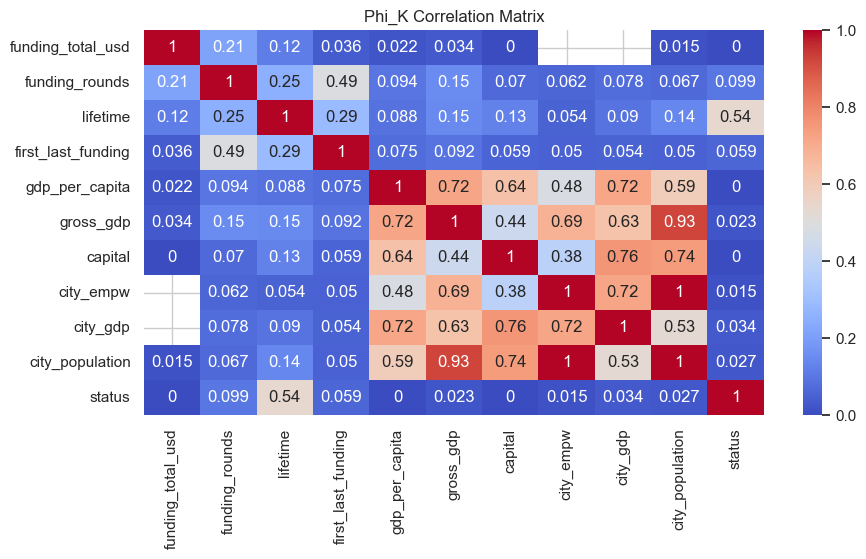

In [83]:
corr_matrix = df_train.phik_matrix(interval_cols=numerical_columns)
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

__Итак__:
- корреляционный анализ с использованием Фик, который проверяет линейные и нелинейные связи показывает высокую вероятность мультиколлинеарности между входными признаками city_population и gross_gdp. Учитывая, что gross_gdp имеет меньше пропусков, то чтож, откажемся от загруженных city_population к сожалению
- наличие умеренной положительной связи между целевым признаком статус и входным lifetime, т.е. сколько дней компания сущетвует
- наличие очень слабой положительной связи между целевым признаком и funding_rounds, first_last_funding , gross gdp, city_empw и city_gdp

## Пайплайн и подбор и обучение моделей

__Попробуем выбрать признаки ниже для моделирования целевого, зафиксируем random state. Предлагаю не делить train на valid и train, а использовать всю выборку для обучения и кросс валидацию для подбора модели и параметров, скейлер возьмем StandardScaler.__

In [84]:
train_final = df_train[['funding_rounds',
                 'lifetime',
                 'first_last_funding',
                 'gross_gdp',
                 'city_empw', 
                 'city_gdp',
                 'status']]
train_final.reset_index(drop=True)
train_final.head()

,funding_rounds,lifetime,first_last_funding,gross_gdp,city_empw,city_gdp,status
0,2,2998,1310,7.255687e+11,1021016.0,81356.0,operating
1,4,4748,1393,2.065652e+13,NaN,NaN,operating
2,3,4383,681,2.065652e+13,NaN,NaN,operating
3,3,5114,1051,NaN,NaN,NaN,operating
4,1,2791,0,2.065652e+13,NaN,NaN,operating


In [85]:
X = train_final.drop(columns='status')
y = train_final['status']

In [86]:
RANDOM_STATE = 42

In [87]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполним пропуски модой
    ('scaler', StandardScaler())
])


models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE)  
}


param_grid = {
    'RandomForest': {
        'RandomForest__n_estimators': [50, 100],
        'RandomForest__max_depth': [10, 20],
        'RandomForest__min_samples_split': [2, 5, 7]
    },
    'CatBoost': {
        'CatBoost__iterations': [100, 200],
        'CatBoost__depth': [4, 6, 10],
        'CatBoost__learning_rate': [0.1, 0.2, 0.3]
    }
}


cv = StratifiedKFold(n_splits=3)
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        (model_name, model)
    ])
    randomized_search = RandomizedSearchCV(pipeline, param_grid[model_name], cv=cv,random_state=RANDOM_STATE ,scoring='f1_weighted', n_jobs=-1)
    randomized_search.fit(X, y)  
    
    

In [88]:
print(f"Лучшая модель и ее параметры {model_name}: {randomized_search.best_params_}")
print(f"Лучшее значение метирики F1 score для модели {model_name}: {randomized_search.best_score_}")

Лучшая модель и ее параметры CatBoost: {'CatBoost__learning_rate': 0.3, 'CatBoost__iterations': 200, 'CatBoost__depth': 4}
Лучшее значение метирики F1 score для модели CatBoost: 0.9459612866124201


__Значение f1 равное 94.6% говорит нам о том, что модель эффекитвна в отделении классов operating и closed друг от друга лишь с небольшим количеством ошибок false positive и false negative предсказаний.__

## Формирование предсказаний для тестовой выборки

In [89]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


__Добавим необходимые синтетические признаки для тестовой выборки__

In [91]:
test = first_last_funding_pipe.transform(test)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                13125 non-null  object        
 1   category_list       12534 non-null  object        
 2   funding_total_usd   10547 non-null  float64       
 3   country_code        11743 non-null  object        
 4   state_code          11430 non-null  object        
 5   region              11536 non-null  object        
 6   city                11538 non-null  object        
 7   funding_rounds      13125 non-null  int64         
 8   first_funding_at    13125 non-null  datetime64[ns]
 9   last_funding_at     13125 non-null  datetime64[ns]
 10  lifetime            13125 non-null  int64         
 11  first_last_funding  13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 1.2+ MB


In [92]:
test = test.merge(gdp_df, on='country_code', how='left')

In [93]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                13125 non-null  object        
 1   category_list       12534 non-null  object        
 2   funding_total_usd   10547 non-null  float64       
 3   country_code        11743 non-null  object        
 4   state_code          11430 non-null  object        
 5   region              11536 non-null  object        
 6   city                11538 non-null  object        
 7   funding_rounds      13125 non-null  int64         
 8   first_funding_at    13125 non-null  datetime64[ns]
 9   last_funding_at     13125 non-null  datetime64[ns]
 10  lifetime            13125 non-null  int64         
 11  first_last_funding  13125 non-null  int64         
 12  gdp_per_capita      11726 non-null  float64       
 13  gross_gdp           11726 non-null  float64   

In [94]:
test = test.merge(oecd_pivoted, on=['country_code', 'city'], how='left')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                13125 non-null  object        
 1   category_list       12534 non-null  object        
 2   funding_total_usd   10547 non-null  float64       
 3   country_code        11743 non-null  object        
 4   state_code          11430 non-null  object        
 5   region              11536 non-null  object        
 6   city                11538 non-null  object        
 7   funding_rounds      13125 non-null  int64         
 8   first_funding_at    13125 non-null  datetime64[ns]
 9   last_funding_at     13125 non-null  datetime64[ns]
 10  lifetime            13125 non-null  int64         
 11  first_last_funding  13125 non-null  int64         
 12  gdp_per_capita      11726 non-null  float64       
 13  gross_gdp           11726 non-null  float64   

__Отберем нужные входные признаки и передадим данные лучшей модели и пайплайну(не забываем про imputer и Scaler) для предсказаний__

In [95]:
X_test = test[['funding_rounds',
                 'lifetime',
                 'first_last_funding',
                 'gross_gdp',
                 'city_empw', 
                 'city_gdp',
                 ]]
X_test.reset_index(drop=True)
X_test.head()

,funding_rounds,lifetime,first_last_funding,gross_gdp,city_empw,city_gdp
0,1,3501,0,1.302524e+10,NaN,NaN
1,1,2717,0,2.065652e+13,NaN,NaN
2,2,1295,126,7.100036e+10,NaN,NaN
3,4,4748,1935,2.065652e+13,2148559.0,1.1
4,1,6209,0,1.725329e+12,784090.0,4.1


In [96]:
best_pipeline = randomized_search.best_estimator_
y_test_pred = best_pipeline.predict(X_test)

In [97]:
results_df = pd.DataFrame({
    'name': test['name'],
    'prediction': y_test_pred
})
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        13125 non-null  object
 1   prediction  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


In [98]:
results_df.head()

,name,prediction
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


In [99]:
results_df.prediction.value_counts()

prediction
operating    12196
closed         929
Name: count, dtype: int64

In [101]:
results_df.to_csv('predictions.csv', index=False)

## Вывод

- В ходе выполненных работ выше удалось:
  - выполнить предобратку данных и EDA
  - добавить ряд дополнительных входных признаков в модель, как gross gdp by country, gdp city, city empw.
  - выполнить корреляционный анализ данных
  - отобрать признаки и выбрать лучшую модель и парамеры к ней (большое кол-во пропусков, особенно в метриках по городам были заполнены модами)
  - было достигнуто значение метрики качества f1 94.6% в кросс валидации на трейне
  - был сформирован прогноз статуса стартапов для тестовой выборки 